# 1.1 Word Embedding

In [1]:
import gensim.downloader

# Download the embeddings
# w2v = gensim.downloader.load('word2vec-google-news-300')
w2v = gensim.models.KeyedVectors.load('word2vec-google-news-300.model', mmap='r')

# 1.2 Data

In [2]:
# read data
from datasets import Dataset, DatasetDict

def read_conll_file(file_path):
    with open(file_path, "r") as f:
        content = f.read().strip()
        sentences = content.split("\n\n")
        data = []
        for sentence in sentences:
            tokens = sentence.split("\n")
            token_data = []
            for token in tokens:
                token_data.append(token.split())
            data.append(token_data)
    return data


train_data = read_conll_file("/mnt/lustre/yuxin/SC4002_G06/datasets/CoNLL2003/eng.train")
validation_data = read_conll_file("/mnt/lustre/yuxin/SC4002_G06/datasets/CoNLL2003/eng.testa")
test_data = read_conll_file("/mnt/lustre/yuxin/SC4002_G06/datasets/CoNLL2003/eng.testb")

/mnt/lustre/yuxin/anaconda3/envs/sc4002/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# prepare data
def convert_to_dataset(data, label_map):
    formatted_data = {"tokens": [], "ner_tags": []}
    for sentence in data:
        tokens = [token_data[0] for token_data in sentence]
        ner_tags = [label_map[token_data[3]] for token_data in sentence]
        formatted_data["tokens"].append(tokens)
        formatted_data["ner_tags"].append(ner_tags)
    return Dataset.from_dict(formatted_data)


label_list = sorted(list(set([token_data[3] for sentence in train_data for token_data in sentence])))
label_map = {label: i for i, label in enumerate(label_list)}

train_dataset = convert_to_dataset(train_data, label_map)
validation_dataset = convert_to_dataset(validation_data, label_map)
test_dataset = convert_to_dataset(test_data, label_map)

In [4]:
label_map

{'B-LOC': 0,
 'B-MISC': 1,
 'B-ORG': 2,
 'I-LOC': 3,
 'I-MISC': 4,
 'I-ORG': 5,
 'I-PER': 6,
 'O': 7}

# Dataset Preparation

In [5]:
import numpy as np

# Out-of-vocabulary (OOV) words
# 1. can be replaced with a special token, such as "<OOV>" or "<UNK>".
# 2. can be ignored.

word2idx = w2v.key_to_index
print(f"whether <UNK> in w2v: {'<UNK>' in word2idx}") # False
print(f"whether <PAD> in w2v: {'<PAD>' in word2idx}") # False

# Add '<UNK>' and '<PAD>' tokens to the vocabulary index
word2idx['<UNK>'] = len(word2idx)
word2idx['<PAD>'] = len(word2idx)

print(f"word2idx['<UNK>']: {word2idx['<UNK>']}")
print(f"word2idx['<PAD>']: {word2idx['<PAD>']}")

# add the '<UNK>' word to the vocabulary of the Word2Vec model
# initialize it with the average of all word vectors in the pretrained embeddings.
unk_vector = np.mean(w2v.vectors, axis=0)
w2v.vectors = np.vstack([w2v.vectors, unk_vector])
print("after insert UNK: ", w2v.vectors.shape)

# add the '<PAD>' word to the vocabulary of the Word2Vec model
# initialize it with a row of zeros in the vectors matrix.
w2v.vectors = np.vstack([w2v.vectors, np.zeros(w2v.vectors[0].shape)])
print("after insert UNK: ", w2v.vectors.shape)


whether <UNK> in w2v: False
whether <PAD> in w2v: False
word2idx['<UNK>']: 3000000
word2idx['<PAD>']: 3000001
after insert UNK:  (3000001, 300)
after insert UNK:  (3000002, 300)


In [6]:
# Map words to Indices
def sentence_to_indices(sentence, vocab):
    return [vocab.get(word, vocab.get('<UNK>')) for word in sentence]

tag2idx = {
    'B-LOC': 0,
    'B-MISC': 1,
    'B-ORG': 2,
    'I-LOC': 3,
    'I-MISC': 4,
    'I-ORG': 5,
    'I-PER': 6,
    'O': 7,
    'PAD': 8
}

In [7]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

class NERDataset(Dataset):
    def __init__(self, sentences, tags, vocab):
        self.sentences = [torch.tensor(sentence_to_indices(sentence, vocab)) for sentence in sentences]
        self.tags = [torch.tensor(tag) for tag in tags]

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx], self.tags[idx]

# Create PyTorch datasets and data loaders
train_dataset = NERDataset(train_dataset['tokens'], train_dataset['ner_tags'], word2idx)
validation_dataset = NERDataset(validation_dataset['tokens'], validation_dataset['ner_tags'], word2idx)
test_dataset = NERDataset(test_dataset['tokens'], test_dataset['ner_tags'], word2idx)

def collate_fn(batch):
    sentences, tags = zip(*batch)
    sentences_padded = pad_sequence(sentences, batch_first=True, padding_value=word2idx['<PAD>'])
    tags_padded = pad_sequence(tags, batch_first=True, padding_value=tag2idx['PAD'])
    return sentences_padded, tags_padded

# Model

In [8]:
embedding_matrix = torch.FloatTensor(w2v.vectors)

class BiLSTMNERModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_of_layers, output_dim):
        super(BiLSTMNERModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=word2idx['<PAD>'], freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_of_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        tag_space = self.fc(lstm_out)
        tag_scores = torch.log_softmax(tag_space, dim=-1)
        return tag_scores

# Utilities

In [9]:
# Hyperparameters
EMBEDDING_DIM = w2v[0].shape[0]
print(f"EMBEDDING_DIM: {EMBEDDING_DIM}")
VOCAB_SIZE = len(word2idx)
print(f"VOCAB_SIZE: {VOCAB_SIZE}")
TAGSET_SIZE = len(tag2idx)
print(f"TAGSET_SIZE: {TAGSET_SIZE}")
MAX_EPOCHS = 50

idx2tag = {v: k for k, v in tag2idx.items()}
def idx_to_tags(indices):
    return [idx2tag[idx] for idx in indices]

class EarlyStopper:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.max_f1 = 0

    def early_stop(self, f1):
        if f1 > self.max_f1:
            self.max_f1 = f1
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

EMBEDDING_DIM: 300
VOCAB_SIZE: 3000002
TAGSET_SIZE: 9


# Hyperparamter Tuning

In [10]:
def evaluate(model, validation_loader, device):
    # print(next(model.parameters()).device) 
    print("evaluate.....")
    # Evaluate on the validation dataset
    # Placeholder to store true and predicted tags
    y_true = [] # true tags
    y_pred = [] # predicted tags
        
    # Evaluate the model on the validation dataset
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for sentences, tags in validation_loader:
            # Move the data to the GPU
            sentences, tags = sentences.to(device), tags.to(device)
            tag_scores = model(sentences)
            # print(tag_scores.device)
            predictions = tag_scores.argmax(dim=-1).tolist()
            # print(predictions)
                
            # Convert index to tags
            # Note: filtering out padding tokens
            for sentence, true_seq, pred_seq in zip(sentences, tags.tolist(), predictions):
                valid_length = (sentence != word2idx['<PAD>']).sum().item()
                true_tags = [idx2tag[idx] for idx in true_seq[:valid_length]]
                pred_tags = [idx2tag[idx] for idx in pred_seq[:valid_length]]
                y_true.append(true_tags)
                y_pred.append(pred_tags)
        
    # Compute F1 score
    f1 = f1_score(y_true, y_pred)
    return f1

In [11]:
import itertools
from torch.optim import SGD, Adagrad, Adam, RMSprop
from sklearn.model_selection import ParameterGrid
from seqeval.metrics import f1_score
from seqeval.metrics import classification_report
from seqeval.scheme import IOB1
import gc  # Python's garbage collector interface
import json
import os

    
# Define the range of hyperparameters
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001, 0.0001],
    'batch_size': [16, 32],
    'optimizer': [SGD, Adagrad, Adam, RMSprop],
    'hidden_dim': [128, 256, 512],
    'num_layers': [1, 2, 3],
}

# Check for a GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

# Function to save the best model to CPU and clear memory
def save_and_clear_best_model(current_best_model, best_state):
    # Save the model state dictionary
    torch.save(current_best_model.state_dict(), best_state)
    # Delete model and empty cache
    del current_best_model
    torch.cuda.empty_cache()

best_model_state = 'best_model_state.pth'

# placeholder for the best model and best F1 score
best_model = None
best_f1_score = 0
best_params = None

# Load existing results if they exist
if os.path.isfile('hyperparameter_tuning_results.json'):
    with open('hyperparameter_tuning_results.json', 'r') as f:
        results = json.load(f)
    existing_combinations = {(result['learning_rate'], result['batch_size'], result['optimizer'], result['hidden_dim'], result['num_layers']) for result in results}
    print(f"Resuming from {len(results)} existing results.")
else:
    results = []
    existing_combinations = set()
    
# Iterate over all combinations
for params in list(ParameterGrid(param_grid)):
    # Skip if this combination has already been evaluated
    if (params['learning_rate'], params['batch_size'], params['optimizer'].__name__, params['hidden_dim'], params['num_layers']) in existing_combinations:
        print("Skipping already evaluated combination:", params)
        continue
    break    
    # set up model
    model = BiLSTMNERModel(EMBEDDING_DIM, params['hidden_dim'], params['num_layers'], TAGSET_SIZE).to(device)
    loss_function = nn.NLLLoss(ignore_index=tag2idx['PAD']).to(device)
    optimizer = params['optimizer'](model.parameters(), lr=params['learning_rate'])
    
    # Initialize dataloaders
    train_loader = DataLoader(train_dataset, params['batch_size'], shuffle=True, collate_fn=collate_fn)
    validation_loader = DataLoader(validation_dataset, params['batch_size'], shuffle=False, collate_fn=collate_fn)

    # Initialize early stopper
    early_stopper = EarlyStopper()
    
    # Training loop
    print("================================================\n", params)
    for epoch in range(MAX_EPOCHS):
        total_loss = 0
        model.train()  # Make sure the model is in training mode
        for sentences, tags in train_loader:
            sentences, tags = sentences.to(device), tags.to(device)  # Move data to GPU
            model.zero_grad()
            tag_scores = model(sentences)
            loss = loss_function(tag_scores.view(-1, TAGSET_SIZE), tags.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss}")
        
        # Evaluate on validation set
        f1_validation = evaluate(model, validation_loader, device)
        print(f"F1 Score (Epoch {epoch+1}): {f1_validation}")
        
        # Early stopping check
        if early_stopper.early_stop(f1_validation):
            print(f"Stopping early at epoch {epoch+1}")
            break
            
    # Record the results
    new_result = {
        'learning_rate': params['learning_rate'],
        'batch_size': params['batch_size'],
        'optimizer': params['optimizer'].__name__,
        'hidden_dim': params['hidden_dim'],
        'num_layers': params['num_layers'],
        'final_epoch': epoch,
        'f1_score': f1_validation
    }
    results.append(new_result)
    # Save the results to the JSON file after each iteration
    with open('hyperparameter_tuning_results.json', 'w') as f:
        json.dump(results, f, indent=4)
        
    # Keep track of the best model
    if f1_validation > best_f1_score:
        best_f1_score = f1_validation
        best_params = params
        print(f"New best F1 score: {best_f1_score}")
        print(f"Best hyperparameters: {best_params}")
        
    # Clean up after each model is evaluated to free GPU memory
    del model
    gc.collect()  # Clean up garbage
    torch.cuda.empty_cache()  # Clear the GPU cache
    print("================================================")

Running on device: cuda:0
Resuming from 157 existing results.
Skipping already evaluated combination: {'batch_size': 16, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_layers': 1, 'optimizer': <class 'torch.optim.sgd.SGD'>}
Skipping already evaluated combination: {'batch_size': 16, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_layers': 1, 'optimizer': <class 'torch.optim.adagrad.Adagrad'>}
Skipping already evaluated combination: {'batch_size': 16, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_layers': 1, 'optimizer': <class 'torch.optim.adam.Adam'>}
Skipping already evaluated combination: {'batch_size': 16, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_layers': 1, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>}
Skipping already evaluated combination: {'batch_size': 16, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_layers': 2, 'optimizer': <class 'torch.optim.sgd.SGD'>}
Skipping already evaluated combination: {'batch_size': 16, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_layers': 2

# Analysis

In [34]:
import json

with open('hyperparameter_tuning_results.json', 'r') as f:
    results = json.load(f)

# sort results by best F1 score
results = sorted(results, key=lambda x: x['f1_score'], reverse=True)

# Print the best hyperparameters
print("Best hyperparameters:", results[0])
print("Best hyperparameters:", results[1])

Best hyperparameters: {'learning_rate': 0.001, 'batch_size': 16, 'optimizer': 'Adam', 'hidden_dim': 128, 'num_layers': 3, 'final_epoch': 20, 'f1_score': 0.9024059640799729}
Best hyperparameters: {'learning_rate': 0.001, 'batch_size': 16, 'optimizer': 'RMSprop', 'hidden_dim': 512, 'num_layers': 2, 'final_epoch': 15, 'f1_score': 0.9001274968125796}


/tmp/ipykernel_12269/541632841.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar1 = sns.barplot(x='optimizer', y='f1_score', data=optimizer_performance, palette=f1_colors)
/tmp/ipykernel_12269/541632841.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar2 = sns.barplot(x='optimizer', y='final_epoch', data=optimizer_performance, palette=epoch_colors)


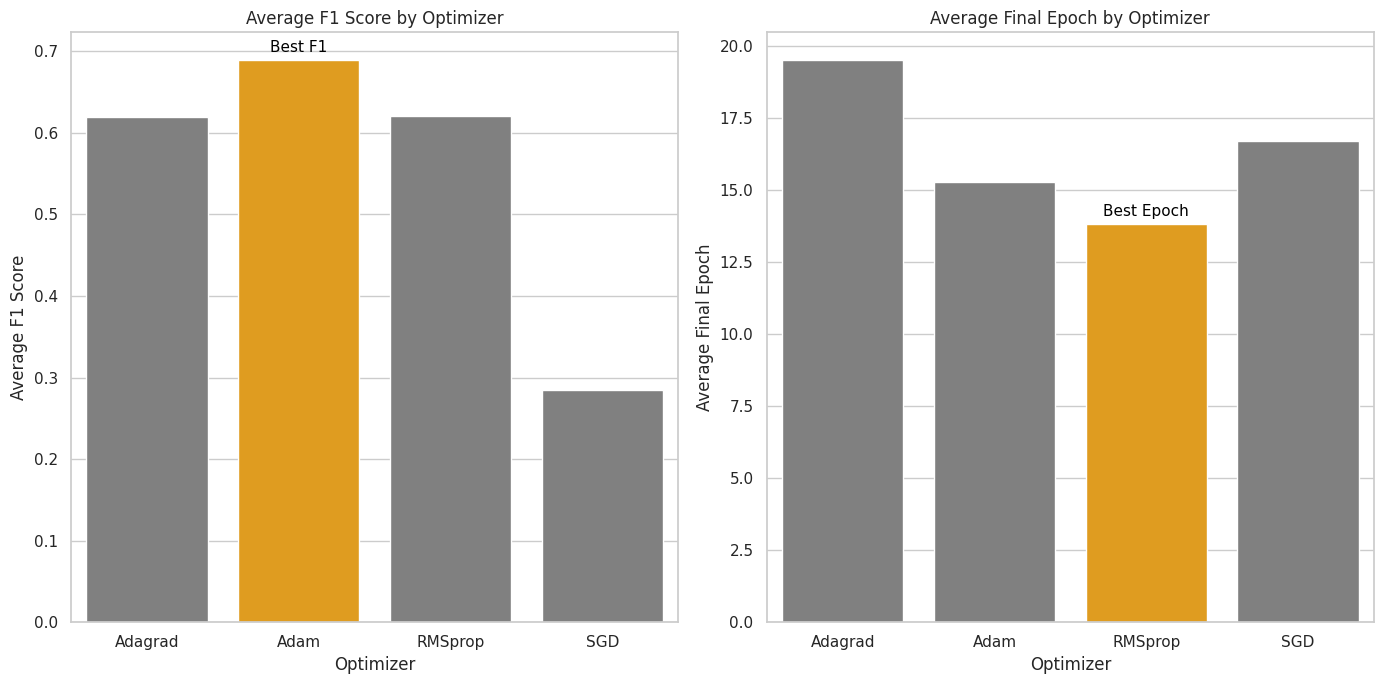

Best optimizer by F1 score: Adam with an average F1 score of 0.6887
Best optimizer by epochs to converge: RMSprop with an average final epoch of 13.8


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the list of dictionaries to a DataFrame for easier analysis
df = pd.DataFrame(results)

# Group the data by optimizer and calculate the mean F1 score and final epoch
optimizer_performance = df.groupby('optimizer').agg({'f1_score': 'mean', 'final_epoch': 'mean'}).reset_index()

# Find the best optimizer considering the average max F1 score
best_optimizer_f1 = optimizer_performance.sort_values(by='f1_score', ascending=False).iloc[0]

# Find the best optimizer considering the average final epoch to convergence
best_optimizer_epoch = optimizer_performance.sort_values(by='final_epoch').iloc[0]

# Define a function to highlight the maximum value in each column
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if cell else '' for cell in is_max]

# color palette
f1_colors = ['orange' if optimizer == best_optimizer_f1['optimizer'] else 'grey' for optimizer in optimizer_performance['optimizer']]
epoch_colors = ['orange' if optimizer == best_optimizer_epoch['optimizer'] else 'grey' for optimizer in optimizer_performance['optimizer']]

# Now let's visualize the data with highlighted best numbers
plt.figure(figsize=(14, 7))

# F1 score by optimizer
plt.subplot(1, 2, 1)
bar1 = sns.barplot(x='optimizer', y='f1_score', data=optimizer_performance, palette=f1_colors)
bar1.set_title('Average F1 Score by Optimizer')
bar1.set_xlabel('Optimizer')
bar1.set_ylabel('Average F1 Score')
# Highlight the best F1 score
for p in bar1.patches:
    if p.get_height() == best_optimizer_f1['f1_score']:
        bar1.annotate('Best F1', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', fontsize=11, color='black', xytext=(0, 9),
                      textcoords='offset points')

# Final epoch by optimizer
plt.subplot(1, 2, 2)
bar2 = sns.barplot(x='optimizer', y='final_epoch', data=optimizer_performance, palette=epoch_colors)
bar2.set_title('Average Final Epoch by Optimizer')
bar2.set_xlabel('Optimizer')
bar2.set_ylabel('Average Final Epoch')
# Highlight the best epoch
for p in bar2.patches:
    if p.get_height() == best_optimizer_epoch['final_epoch']:
        bar2.annotate('Best Epoch', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', fontsize=11, color='black', xytext=(0, 9),
                      textcoords='offset points')

plt.tight_layout()
plt.savefig('tuning-1.png')
plt.show()

# Print out the best optimizer considering F1 score and epochs to converge
print(f"Best optimizer by F1 score: {best_optimizer_f1['optimizer']} with an average F1 score of {best_optimizer_f1['f1_score']:.4f}")
print(f"Best optimizer by epochs to converge: {best_optimizer_epoch['optimizer']} with an average final epoch of {best_optimizer_epoch['final_epoch']:.1f}")

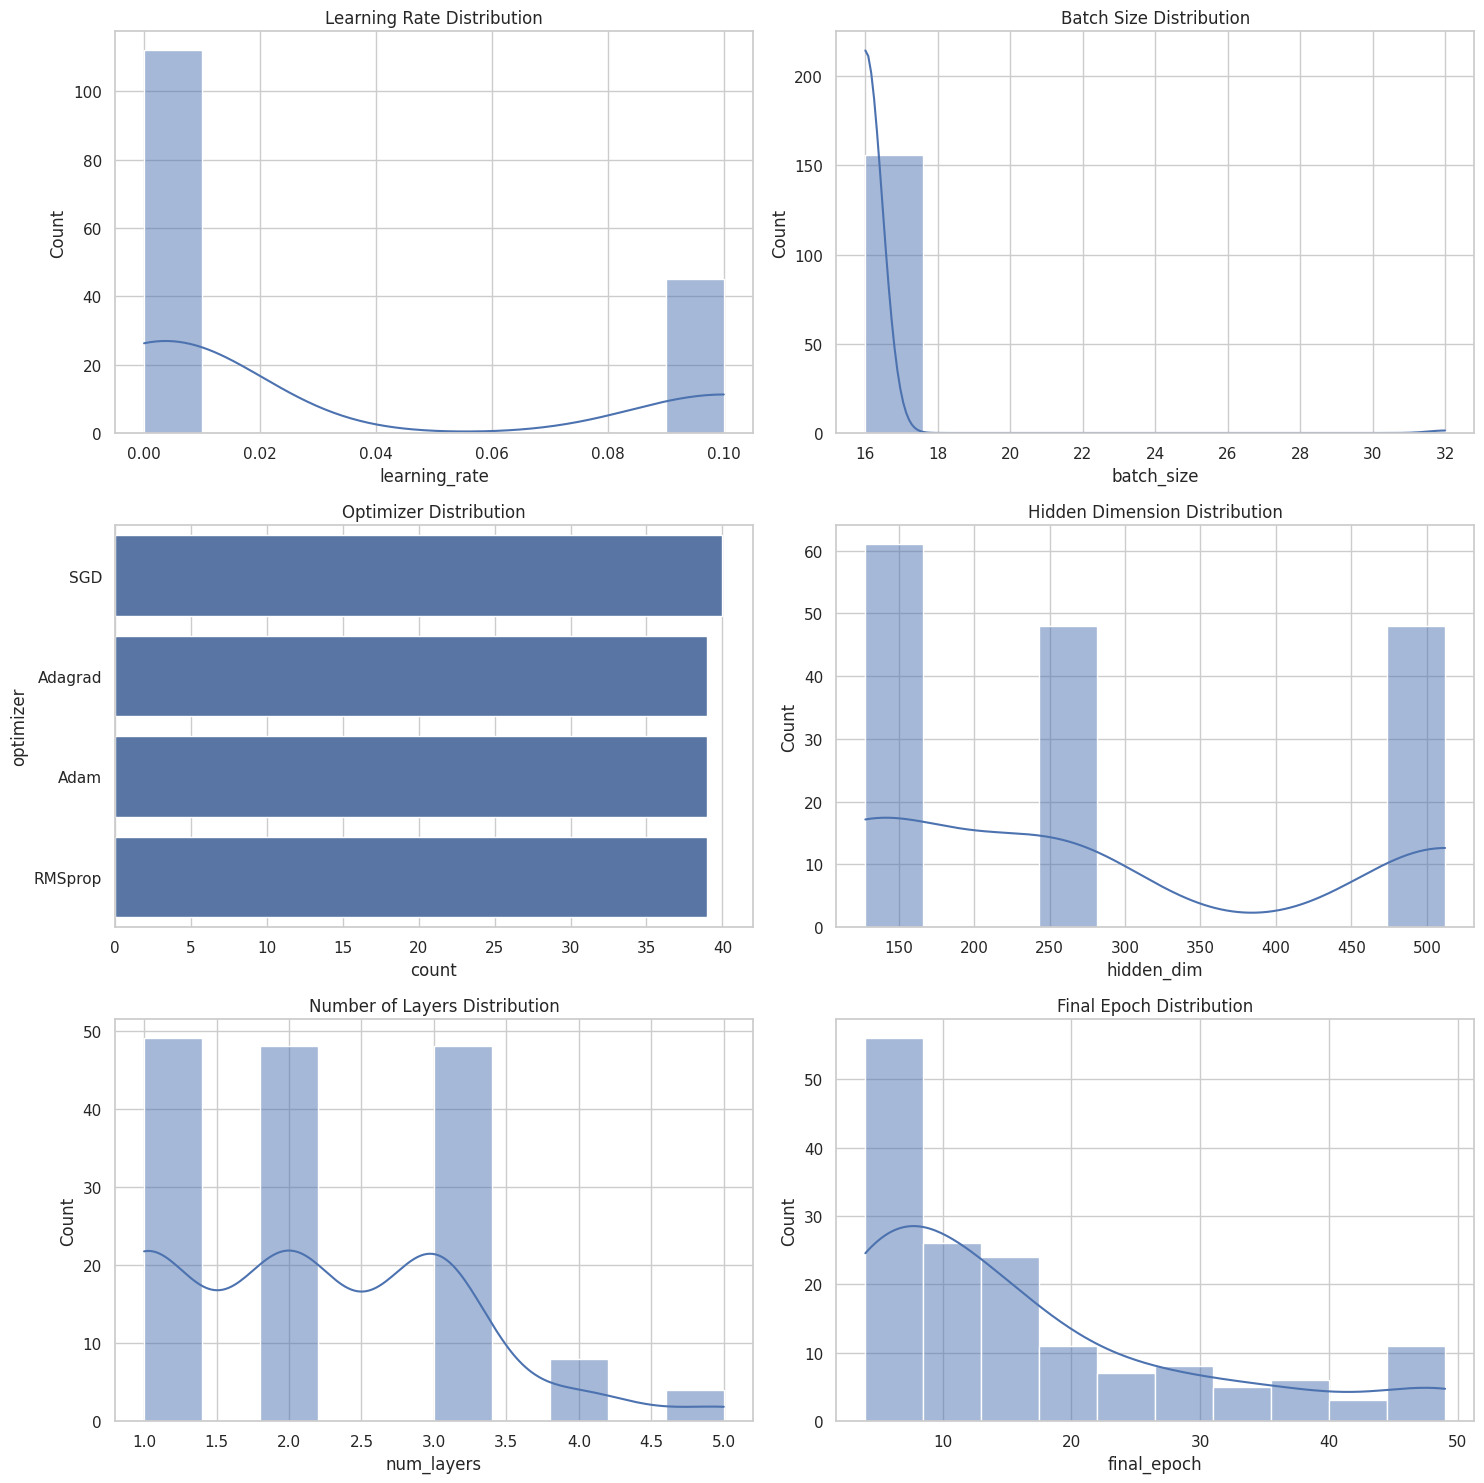

In [36]:
# To avoid randomness, we visualize the distribution of hyperparameters for settings where the f1_score is above 0.89.

filtered_data = pd.read_json('hyperparameter_tuning_results.json')

# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Create subplots for the distribution of hyperparameters
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Learning Rate distribution
sns.histplot(data=filtered_data, x='learning_rate', bins=10, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Learning Rate Distribution')

# Batch Size distribution
sns.histplot(data=filtered_data, x='batch_size', bins=10, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Batch Size Distribution')

# Optimizer distribution
sns.countplot(data=filtered_data, y='optimizer', ax=axs[1, 0])
axs[1, 0].set_title('Optimizer Distribution')

# Hidden Dimension distribution
sns.histplot(data=filtered_data, x='hidden_dim', bins=10, kde=True, ax=axs[1, 1])
axs[1, 1].set_title('Hidden Dimension Distribution')

# Number of Layers distribution
sns.histplot(data=filtered_data, x='num_layers', bins=10, kde=True, ax=axs[2, 0])
axs[2, 0].set_title('Number of Layers Distribution')

# Final Epoch distribution
sns.histplot(data=filtered_data, x='final_epoch', bins=10, kde=True, ax=axs[2, 1])
axs[2, 1].set_title('Final Epoch Distribution')

plt.tight_layout()
plt.savefig('tuning-2.png')
plt.show()